<a href="https://colab.research.google.com/github/nmaguette/machine_learning_workshops/blob/master/Maguette_D2_ML_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project



In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import random

from skimage.color import rgb2gray #skimage : image manipulation library
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.utils import shuffle


# 1. Image classification on Caltech 101

**a)** Download images from
http://www.vision.caltech.edu/feifeili/Datasets.htm
and run the code bellow to check the files and store the name of the classes in the list ```labelNamesAll```

In [0]:
!pip install wget
!wget 'http://www.vision.caltech.edu/feifeili/101_ObjectCategories.tar.gz'
!tar -xvf 101_ObjectCategories.tar.gz 101_ObjectCategories

--2019-10-29 14:48:52--  http://www.vision.caltech.edu/feifeili/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz.4’

101_ObjectCategorie 100%[===================>] 125.64M  24.9MB/s    in 5.8s    

2019-10-29 14:48:58 (21.8 MB/s) - ‘101_ObjectCategories.tar.gz.4’ saved [131740031/131740031]

101_ObjectCategories/
101_ObjectCategories/BACKGROUND_Google/
101_ObjectCategories/BACKGROUND_Google/tmp
101_ObjectCategories/BACKGROUND_Google/image_0004.jpg
101_ObjectCategories/BACKGROUND_Google/image_0005.jpg
101_ObjectCategories/BACKGROUND_Google/image_0006.jpg
101_ObjectCategories/BACKGROUND_Google/image_0007.jpg
101_ObjectCategories/BACKGROUND_Google/image_0008.jpg
101_ObjectCategories/BACKGROUND_Google/image_0010.jpg


In [0]:
## VERIFY LOCATION AND STORE LABEL NAMES

IMDIR = '101_ObjectCategories/'
labelNamesAll = []

for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)
    #uncomment to check what is found in this folder
    #for filename in filenames:
        #f = os.path.join(root, filename)
        #if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
        #    print(f)

labelNamesAll = labelNamesAll[0]

#The list of all labels/directories is
print(labelNamesAll)

['wheelchair', 'soccer_ball', 'cellphone', 'scissors', 'rhino', 'nautilus', 'watch', 'starfish', 'scorpion', 'stop_sign', 'car_side', 'pyramid', 'stapler', 'brontosaurus', 'metronome', 'ibis', 'beaver', 'pizza', 'dolphin', 'cup', 'BACKGROUND_Google', 'airplanes', 'hawksbill', 'Leopards', 'umbrella', 'elephant', 'Faces', 'ketch', 'sea_horse', 'gerenuk', 'chair', 'bass', 'kangaroo', 'camera', 'binocular', 'garfield', 'mayfly', 'grand_piano', 'bonsai', 'rooster', 'ewer', 'llama', 'ceiling_fan', 'yin_yang', 'lobster', 'schooner', 'headphone', 'octopus', 'helicopter', 'okapi', 'Faces_easy', 'Motorbikes', 'joshua_tree', 'emu', 'pigeon', 'crocodile', 'laptop', 'wrench', 'menorah', 'pagoda', 'cougar_body', 'butterfly', 'cougar_face', 'lamp', 'ant', 'sunflower', 'wild_cat', 'minaret', 'dollar_bill', 'brain', 'snoopy', 'platypus', 'mandolin', 'saxophone', 'revolver', 'strawberry', 'chandelier', 'trilobite', 'accordion', 'tick', 'buddha', 'cannon', 'water_lilly', 'windsor_chair', 'inline_skate', 

**b. Build a reduced dataset for accelerating process.** To do so: 
- Consider only up to $K$ randomly drawn categories (start with a binary case)
- Read only up to $N$ images for each class
- Resize the images to $(imWidth*imHeight)$

The dataset should consist of a 
- Input matrix $\mathbf{X}$ of size $(K\cdot N)\times (imWidth\cdot imHeight)$ with one image in every row of the matrix. 
- Output vector $\mathbf{y}$ of size $(K\cdot N)\times 1$ with the label index of each input point in $\bf X$.
- the reduced list of the label names of size $K$ to map between the indices and the names.

**Note than different classes may have different number of images so that the actual number of $\bf X$ and $\bf y$ is less than $K*N$**

(Run and understand)

In [0]:
#build DATASET from K categories and (up to) N images from category
K = 2
N = 40
imWidth = 100
imHeight = 100
def reduce_dataset(K=2,N=40,imHeight=100,imWidth=100, rnd_seed=42):
  #selection of label indices
  X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
  #Y = np.zeros([K*N,1]) #label indices
  Y = -np.ones([K*N,1]) #label indices
  labelNames = []

  random.seed(rnd_seed)

  globalCount = 0
  for i in range(K): 
      while True:
          lab = random.randint(0,len(labelNamesAll)-1)
          if lab not in labelNames:
              break
      #folders are named after the class label
      filedir = os.path.join(IMDIR,labelNamesAll[lab])
      print(filedir)

      #save the name of the class
      labelNames.append(labelNamesAll[lab])       

      classCount = 0
      for filename in os.listdir(filedir):
          f = os.path.join(filedir, filename)
          if f.endswith(('.jpg')) and (classCount < N):
              image = skimage.io.imread(f, as_gray=True)
              image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
              X[globalCount,:] = image.flatten()
              Y[globalCount,:] = i
              globalCount += 1
              classCount += 1

  #Remove the unused entries of X and Y
  print(globalCount)
  X = X[:globalCount,:]
  Y = Y[:globalCount,:]

  #Check the stored classes
  print("labelNames:",labelNames)
  print("X.shape:",X.shape)
  print("output vector Y:\n",Y.T)
  
  return X,Y,labelNames

X, Y,labelNames = reduce_dataset(K,N,imHeight,imWidth)

101_ObjectCategories/cannon
101_ObjectCategories/metronome
72
labelNames: ['cannon', 'metronome']
X.shape: (72, 10000)
output vector Y:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


**c. Split the dataset into train (80% of samples) and test (20% samples).**
(Fill in)

In [0]:
def split_data(X, Y):
  X, Y = shuffle(X, Y, random_state=42)
  print("shuffled Y:\n",Y.T)

  X_train = X[:int(0.8*X.shape[0])]
  X_test = X[int(0.8*X.shape[0]):]
  Y_train = Y[:int(0.8*X.shape[0])]
  Y_test = Y[int(0.8*X.shape[0]):]


  print("X_train.shape:",X_train.shape)
  print("X_test.shape:",X_test.shape)
  print("Y_train:",Y_train.T)
  print("Y_test:",Y_test.T)
  return X_train,X_test,Y_train,Y_test

X_train,X_test,Y_train,Y_test = split_data(X, Y)

shuffled Y:
 [[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]]
X_train.shape: (57, 10000)
X_test.shape: (15, 10000)
Y_train: [[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 0.]]
Y_test: [[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]]


**d) Create an SVC model, train it on the train set, and test it on the test set**. 
(Fill in and answer the questions)

In [0]:
# Create, train and test an svm model    
def sk_svm_model(X_train,X_test,Y_train,Y_test, multiclass):
  svc_model = SVC(decision_function_shape=multiclass)
  svc_model.fit(X_train, Y_train)

  Y_pred=svc_model.predict(X_test)

  print("True classes",Y_test.T)
  print("Predictions",Y_pred)
  errors = np.sum((Y_test.ravel()!=Y_pred))
  print('There were', errors, 'errors')
  return errors, Y_pred

error1, Y_pred = sk_svm_model(X_train,X_test,Y_train,Y_test, 'ovr')

True classes [[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]]
Predictions [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
There were 5 errors


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**Question** SVMs are intrinsically binary classifiers, can you train the SVC for K>2? How is that achieved?

<font color=green>Yes, we can train the SVC for **K>2** by using the multiclass method **one-vs-one** of **SVC** in *SciKitLearn*.
> Option : *decision_function_shape='ovo'*

<font color=green>For other multiclass methods as **one-vs-all & continuous one-vs-all**, 
we can use the **linearSVC** model in *SciKitLearn*.
> Options : *multi_class='ovr'* or *multi_class='crammer_singer'*

Here is a quick lookup guide on one-vs-one and one-vs-all [multiclass models for all SciKit Learn libraries](https://scikit-learn.org/stable/modules/multiclass.html).

[Multi-class-classification for SVM models only](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification)

**e) Fill in the function bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix values TP, TN, FP, FN
![image](confusion-matrix.png)

**Question:** What are the different manners to compute and interpret the scores for multiple classes $K>2$ ? Implement them

**Hint** Add a numerical zero eps to the denominators to prevent dividing by zero

In [0]:
# Functions to compute the errors between prediction and ground truth 

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)

    Y_gt_c = Y_gt.copy()
    Y_pred_c = Y_pred.copy()

    # one vs all
    for i in range(Y_len):
        if Y_gt[i]==positiveClass:
            Y_gt_c[i]=1
        else:
            Y_gt_c[i]=0
        if Y_pred[i]==positiveClass:
            Y_pred_c[i]=1
        else:
            Y_pred_c[i]=0

    eps = 1e-12
    
    # True positives TP
    TP = np.sum(np.logical_and((Y_pred_c==1),(Y_gt_c.ravel()==Y_pred_c)))
        
    # True negatives TN
    TN = np.sum(np.logical_and((Y_pred_c==0),(Y_gt_c.ravel()==Y_pred_c)))
    
    # False positives FP
    FP = np.sum(np.logical_and((Y_pred_c==1),(Y_gt_c.ravel()!=Y_pred_c)))
        
    # False negatives FN
    FN = np.sum(np.logical_and((Y_pred_c==0),(Y_gt_c.ravel()!=Y_pred_c)))

    print('TP :', TP, '\nTN :', TN, '\nFP :', FP, '\nFN :', FN, '\nTotal :', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    # Accuracy
    measures['accuracy'] = (TP+TN)/(Y_len+eps)
    
    # Precision
    measures['precision'] = TP/(TP+FP+eps)
        
    # Specificity
    measures['specificity']= TN/(TN+FP+eps)
    
    # Recall
    measures['recall'] = TP/(TP+FN+eps)
    
    # F-measure
    measures['f1'] = (2*measures['precision']*measures['recall'])/(measures['precision']+measures['recall']+eps)
    
    # Negative Predictive Value
    measures['npv'] = TN/(TN+FN+eps)
    
    # False Predictive Value #or False Positive Rate
    measures['fpr'] = 1 - measures['specificity']   # or FP/(TN+FP)
    
    print("\nMEASURES CALCULATION:")
    print('Accuracy ', measures['accuracy'],
          '\nPrecision', measures['precision'],
          '\nRecall', measures['recall'],
          '\nSpecificity ', measures['specificity'],
          '\nF-measure', measures['f1'],
          '\nNPV', measures['npv'],
          '\nFPV', measures['fpr'])

    return measures

measures = compute_measures(Y_test,Y_pred, positiveClass=1)

TP : 2 
TN : 8 
FP : 0 
FN : 5 
Total : 15

MEASURES CALCULATION:
Accuracy  0.6666666666666222 
Precision 0.9999999999995 
Recall 0.2857142857142449 
Specificity  0.999999999999875 
F-measure 0.44444444444399994 
NPV 0.615384615384568 
FPV 1.2501111257279263e-13


In [0]:
def micro_average(measuresList):
    microAverage = dict()
    eps = 1e-12
    
    sum_TP = np.sum(np.array([measure['TP'] for measure in measuresList]))
    sum_TN = np.sum(np.array([measure['TN'] for measure in measuresList]))
    sum_FP = np.sum(np.array([measure['FP'] for measure in measuresList]))
    sum_FN = np.sum(np.array([measure['FN'] for measure in measuresList]))

    # Accuracy
    microAverage['accuracy'] = (sum_TP+sum_TN)/(sum_TP+sum_TN+sum_FP+sum_FN+eps)
    
    # Precision
    microAverage['precision'] = sum_TP/(sum_TP+sum_FP+eps)
        
    # Specificity
    microAverage['specificity'] = sum_TN/(sum_TN+sum_FP+eps)
    
    # Recall
    microAverage['recall'] = sum_TP/(sum_TP+sum_FN+eps)
    
    # F-measure
    microAverage['f1'] = (2*microAverage['precision']*microAverage['recall'])/(microAverage['precision']+microAverage['recall']+eps)
    
    # Negative Predictive Value
    microAverage['npv'] = sum_TN/(sum_TN+sum_FN+eps)
    
    # False Predictive Value
    microAverage['fpr'] = sum_FP/(sum_TN+sum_FP+eps)
    
    print("\nMICRO_AVERAGE MEASURES CALCULATION:")
    print('Accuracy ', microAverage['accuracy'],
          '\nPrecision', microAverage['precision'],
          '\nRecall', microAverage['recall'],
          '\nSpecificity ', microAverage['specificity'],
          '\nF-measure', microAverage['f1'],
          '\nNPV', microAverage['npv'],
          '\nFPV', microAverage['fpr'])
    
    return microAverage

microAverage = micro_average([measures])


MICRO_AVERAGE MEASURES CALCULATION:
Accuracy  0.6666666666666222 
Precision 0.9999999999995 
Recall 0.2857142857142449 
Specificity  0.999999999999875 
F-measure 0.44444444444399994 
NPV 0.615384615384568 
FPV 0.0


In [0]:
def macro_average(measuresList):
    macroAverage = dict()
    n = len(measuresList)
    # Accuracy
    macroAverage['accuracy'] = np.sum(np.array([measure['accuracy'] for measure in measuresList]))/n
    
    # Precision
    macroAverage['precision'] = np.sum(np.array([measure['precision'] for measure in measuresList]))/n
        
    # Specificity
    macroAverage['specificity']= np.sum(np.array([measure['specificity'] for measure in measuresList]))/n
    
    # Recall
    macroAverage['recall'] = np.sum(np.array([measure['recall'] for measure in measuresList]))/n
    
    # F-measure
    macroAverage['f1'] = np.sum(np.array([measure['f1'] for measure in measuresList]))/n
    
    # Negative Predictive Value
    macroAverage['npv'] = np.sum(np.array([measure['npv'] for measure in measuresList]))/n
    
    # False Predictive Value
    macroAverage['fpr'] = np.sum(np.array([measure['fpr'] for measure in measuresList]))/n
    
    print("\nMACRO_AVERAGE MEASURES CALCULATION:")
    print('Accuracy ', macroAverage['accuracy'],
          '\nPrecision', macroAverage['precision'],
          '\nRecall', macroAverage['recall'],
          '\nSpecificity ', macroAverage['specificity'],
          '\nF-measure', macroAverage['f1'],
          '\nNPV', macroAverage['npv'],
          '\nFPV', macroAverage['fpr'],'\n')
    
    return macroAverage

macroAverage = macro_average([measures])


MACRO_AVERAGE MEASURES CALCULATION:
Accuracy  0.6666666666666222 
Precision 0.9999999999995 
Recall 0.2857142857142449 
Specificity  0.999999999999875 
F-measure 0.44444444444399994 
NPV 0.615384615384568 
FPV 1.2501111257279263e-13 



**e) Measure the performance of the SVC model for multiple classes $K>2$** 

In [0]:
#Fill in a list of measure dictionaries taking as input a different positive class

X, Y, labelNames = reduce_dataset(K=3)
X_train,X_test,Y_train,Y_test = split_data(X,Y)
errors,Y_pred=sk_svm_model(X_train,X_test,Y_train,Y_test, 'ovo')
multiclass = [compute_measures(Y_test,Y_pred,i_class) for i_class in np.unique(Y_test)]
"""for k in range(K):
    print('For class',labelNames[k])
    multiclass.append(compute_measures(Y_test.ravel(),Y_pred, positiveClass=k))"""

print('Macro-average')
macro_average(multiclass)
    
print('Micro-average')
micro_average(multiclass)

from sklearn.metrics import classification_report #confusion_matrix, accuracy_score, precision_score, recall_score, f1_micro, f1_macro
print(classification_report(Y_test.ravel(), Y_pred, target_names=labelNames))

101_ObjectCategories/cannon
101_ObjectCategories/metronome
101_ObjectCategories/scissors
111
labelNames: ['cannon', 'metronome', 'scissors']
X.shape: (111, 10000)
output vector Y:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]]
shuffled Y:
 [[2. 0. 0. 2. 1. 1. 0. 1. 2. 0. 2. 2. 0. 2. 0. 1. 1. 2. 2. 1. 0. 0. 1. 0.
  0. 0. 1. 2. 0. 1. 2. 2. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 2. 0. 1. 0.
  1. 1. 2. 0. 0. 2. 2. 0. 0. 2. 1. 0. 2. 0. 0. 0. 0. 2. 0. 2. 2. 2. 1. 1.
  2. 1. 2. 1. 2. 2. 1. 1. 1. 2. 1. 2. 0. 2. 1. 1. 2. 0. 0. 2. 0. 1. 0. 0.
  0. 2. 2. 2. 2. 2. 2. 0. 1. 1. 2. 0. 2. 1. 2.]]
X_train.shape: (88, 10000)
X_test.shape: (23, 10000)
Y_train: [[2. 0. 0. 2. 1. 1. 0. 1. 2. 0. 2. 2. 0. 2. 0. 1. 1. 2

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


**f) Show the test images as well as the the predictions (Y_pred) vs the ground truth (Y_gt) labels for the best model**
(Just run for each analysed model)

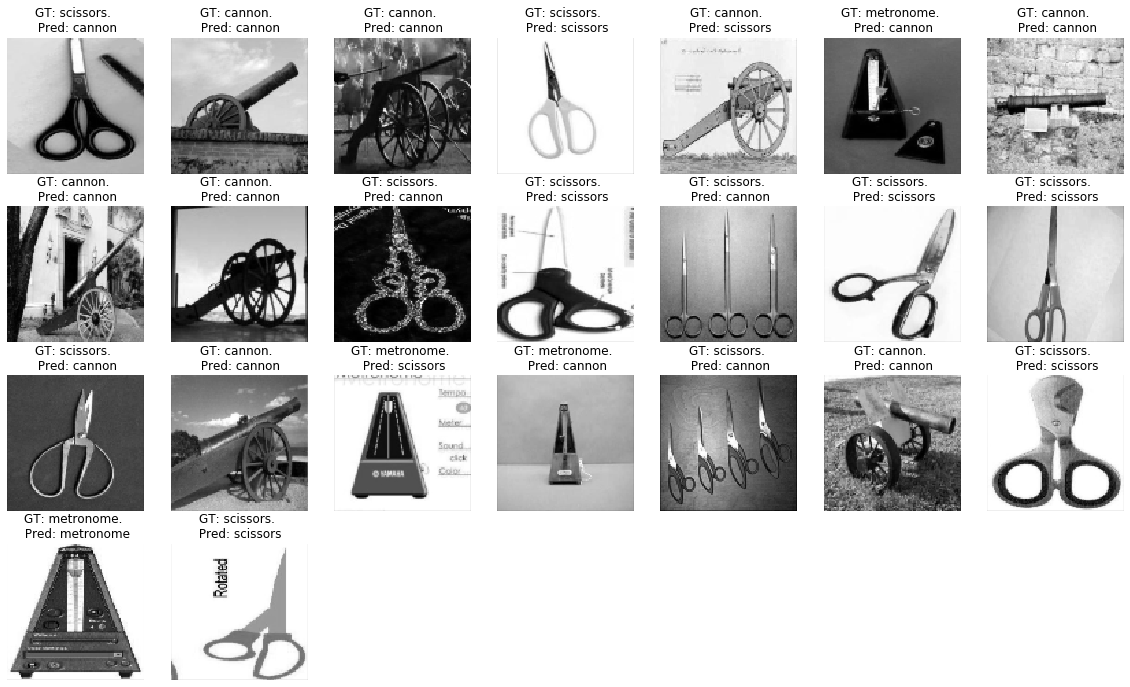

In [0]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]
fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_pred.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


**g) REPORT:**  Change the hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model tried. Present and discuss your findings for different hyperparameters, number of classes and numbers of images. THIS IS THE MOST IMPORTANT PART FOR THE EVALUATION. 

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

for K in range(2,3):
  for N in range(40,60,10):
    X, Y, labelNames = reduce_dataset(K=K, N=N)
    X_train,X_test,Y_train,Y_test = split_data(X,Y)

    param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                  'degree' : [3, 4, 5],
                  'coef0' : [0.0, 3.5, -2.35],
                  'decision_function_shape': ['ovo']}
    model = SVC(gamma='auto')
    gridsearch = GridSearchCV(model, param_grid, cv = 5) #, verbose= 1)
    gridsearch.fit(X_train, Y_train)

    print("The best score is: %s for best parameters: %s" % (gridsearch.best_score_,gridsearch.best_params_))

    Y_train_pred = gridsearch.predict(X_train)
    Y_test_pred = gridsearch.predict(X_test)

    print("Training Accuracy: %.2f " % (accuracy_score(Y_train_pred, Y_train)))
    print("Testing Accuracy: %.2f " % (accuracy_score(Y_test_pred, Y_test)))

    """print("True classes",Y_test.T)
    print("Predictions",Y_test_pred)"""
    """errors = np.sum((Y_test.ravel()!=Y_test_pred.ravel()))
    print('There were', errors, 'errors')"""

    #print(classification_report(Y_test.ravel(), Y_test_pred, target_names=labelNames))
    multiclass = [compute_measures(Y_test,Y_test_pred,i_class) for i_class in np.unique(Y_test)]

    print('\nMacro-average')
    macro_average(multiclass)
    print('Micro-average')
    micro_average(multiclass)

101_ObjectCategories/cannon
101_ObjectCategories/metronome
72
labelNames: ['cannon', 'metronome']
X.shape: (72, 10000)
output vector Y:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
shuffled Y:
 [[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]]
X_train.shape: (57, 10000)
X_test.shape: (15, 10000)
Y_train: [[0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 1. 0. 1. 1. 0. 0.]]
Y_test: [[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

The best score is: 0.7543859649122807 for best parameters: {'coef0': -2.35, 'decision_function_shape': 'ovo', 'degree': 3, 'kernel': 'poly'}
Training Accuracy:  1 
Testing Accuracy:  1 
TP : 8 
TN : 5 
FP : 2 
FN : 0 
Total : 15

MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.79999999999992 
Recall 0.999999999999875 
Specificity  0.7142857142856123 
F-measure 0.8888888888882962 
NPV 0.9999999999997999 
FPV 0.28571428571438773
TP : 5 
TN : 8 
FP : 0 
FN : 2 
Total : 15

MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.9999999999997999 
Recall 0.7142857142856123 
Specificity  0.999999999999875 
F-measure 0.8333333333327083 
NPV 0.79999999999992 
FPV 1.2501111257279263e-13

Macro-average

MACRO_AVERAGE MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.89999999999986 
Recall 0.8571428571427436 
Specificity  0.8571428571427436 
F-measure 0.8611111111105023 
NPV 0.89999999999986 
FPV 0.14285714285725637 

Micro-average

MICRO_AVERAGE MEASURES CAL

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

The best score is: 0.8 for best parameters: {'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'kernel': 'linear'}
Training Accuracy:  1 
Testing Accuracy:  1 
TP : 7 
TN : 6 
FP : 1 
FN : 1 
Total : 15

MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.8749999999998906 
Recall 0.8749999999998906 
Specificity  0.8571428571427346 
F-measure 0.8749999999993906 
NPV 0.8571428571427346 
FPV 0.14285714285726536
TP : 6 
TN : 7 
FP : 1 
FN : 1 
Total : 15

MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.8571428571427346 
Recall 0.8571428571427346 
Specificity  0.8749999999998906 
F-measure 0.8571428571422346 
NPV 0.8749999999998906 
FPV 0.12500000000010936

Macro-average

MACRO_AVERAGE MEASURES CALCULATION:
Accuracy  0.8666666666666089 
Precision 0.8660714285713127 
Recall 0.8660714285713127 
Specificity  0.8660714285713127 
F-measure 0.8660714285708127 
NPV 0.8660714285713127 
FPV 0.13392857142868736 

Micro-average

MICRO_AVERAGE MEASURES CALCULATION

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
